In [74]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [75]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [76]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [77]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [78]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [79]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [80]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [81]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [82]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [83]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
        filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all() 

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])
precipitation_df.set_index('date', inplace = True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')
precipitation_df.head()


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


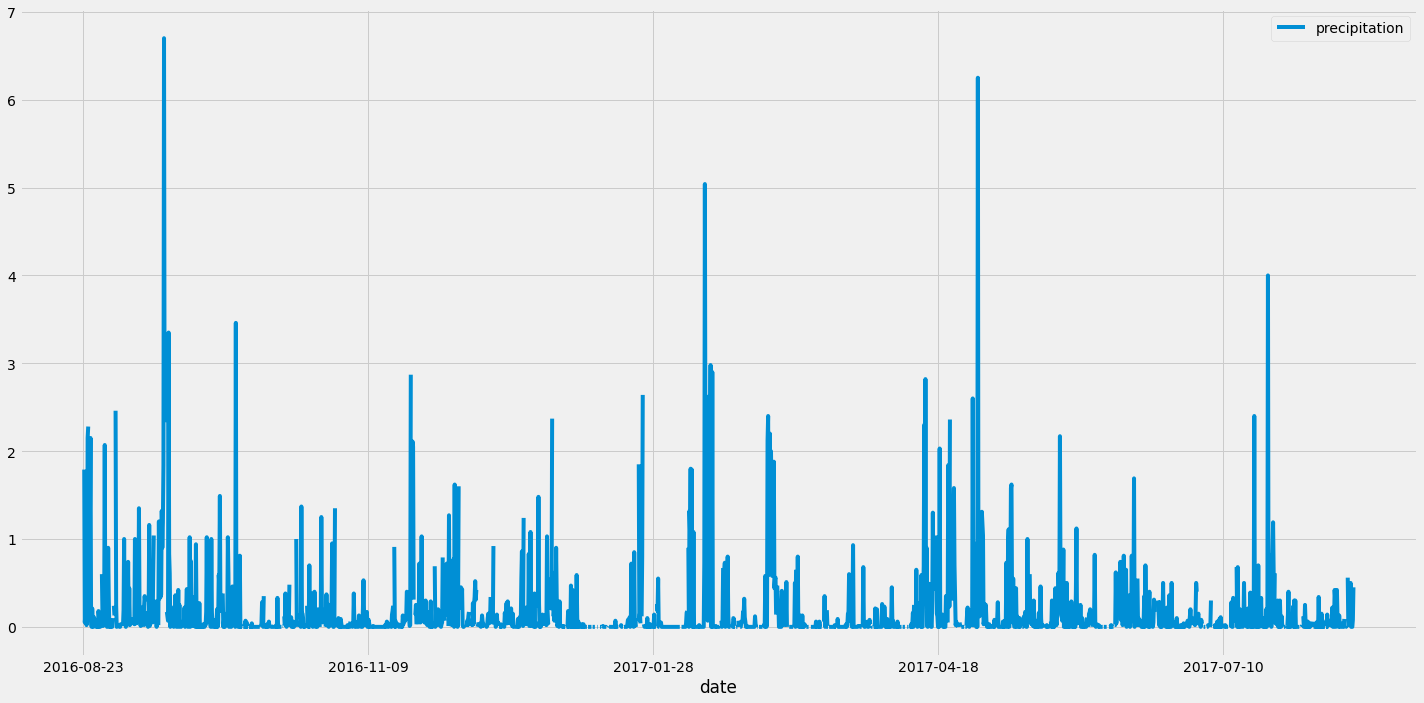

In [84]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (20, 10))
precipitation_df.plot(ax = ax, x_compat = True)

plt.savefig("Images/precipitation.png")

plt.tight_layout()
plt.show()

In [85]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe

<bound method NDFrame.describe of             precipitation
date                     
2016-08-23           0.00
2016-08-23            NaN
2016-08-23           1.79
2016-08-23           0.05
2016-08-23           0.15
...                   ...
2017-08-22           0.00
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.08
2017-08-23           0.45

[2230 rows x 1 columns]>

# Exploratory Station Analysis

In [87]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(9,)

In [88]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = (session.query(Measurement.station, func.count(Measurement.station))
                  .group_by(Measurement.station)
                  .order_by(func.count(Measurement.station).desc())
                  .all())
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [89]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
temps

[(54.0, 85.0, 71.66378066378067)]

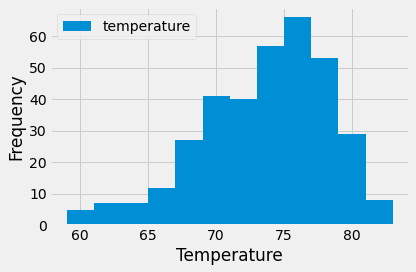

In [90]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

#save as a data frame
temp_observation_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])

fig, ax = plt.subplots()
temp_observation_df.plot.hist(bins = 12, ax = ax)

#labels
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')

#save figure
plt.savefig("Images/yearly_plot.png")

#plot
plt.tight_layout()
plt.show()

In [91]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [92]:
trip_temps = calc_temps('2017-04-02','2017-04-09')
trip_temps

[(67.0, 74.42, 79.0)]

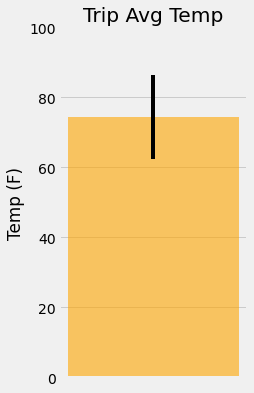

In [93]:
min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(3,6))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'orange', alpha=.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])

plt.show()

# Close session

In [94]:
# Close Session
session.close()